In [63]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
import gc
from wordcloud import WordCloud,STOPWORDS
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import time
from sklearn.model_selection import KFold, RepeatedKFold,train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

os.getcwd()
os.chdir("\\\\CHRB1067.CORP.GWPNET.COM\\homes\\C\\S5RXCY\\Documents\\\\HactionLab\\Task 3 - LCAT classification")


In [64]:
train = pd.read_excel("Task3 (2).xlsx")

In [65]:
train.head()

,Disaster Name,Wikipedia Link,Lcat_Scenario,L-CAT ScenGroup,Lcat_id
0,1900 Hull–Ottawa fire,https://en.wikipedia.org/wiki/1900_Hull%E2%80%...,Brush fires due to bad maintenance,Utility Catastrophe,9016
1,Bento Rodrigues dam disaster,https://en.wikipedia.org/wiki/Bento_Rodrigues_...,Break of Tailing dam,Utility Catastrophe,9015
2,Black Saturday bushfires,https://en.wikipedia.org/wiki/Black_Saturday_b...,Brush fires due to bad maintenance,Utility Catastrophe,9016
3,1998 Jesse pipeline explosion,https://en.wikipedia.org/wiki/1998_Jesse_pipel...,"Interupted Gas Supply, pipeline bust, explosion",Utility Catastrophe,9018
4,2014 Kaohsiung gas explosions,https://en.wikipedia.org/wiki/2014_Kaohsiung_g...,"interupted Gas Supply, pipeline bust, explosion",Utility Catastrophe,9018


In [66]:
import seaborn as sns
sns.set_style("whitegrid")

In [67]:
train["Lcat_Scenario"] = train["Lcat_Scenario"].apply(lambda x: str(x).strip())

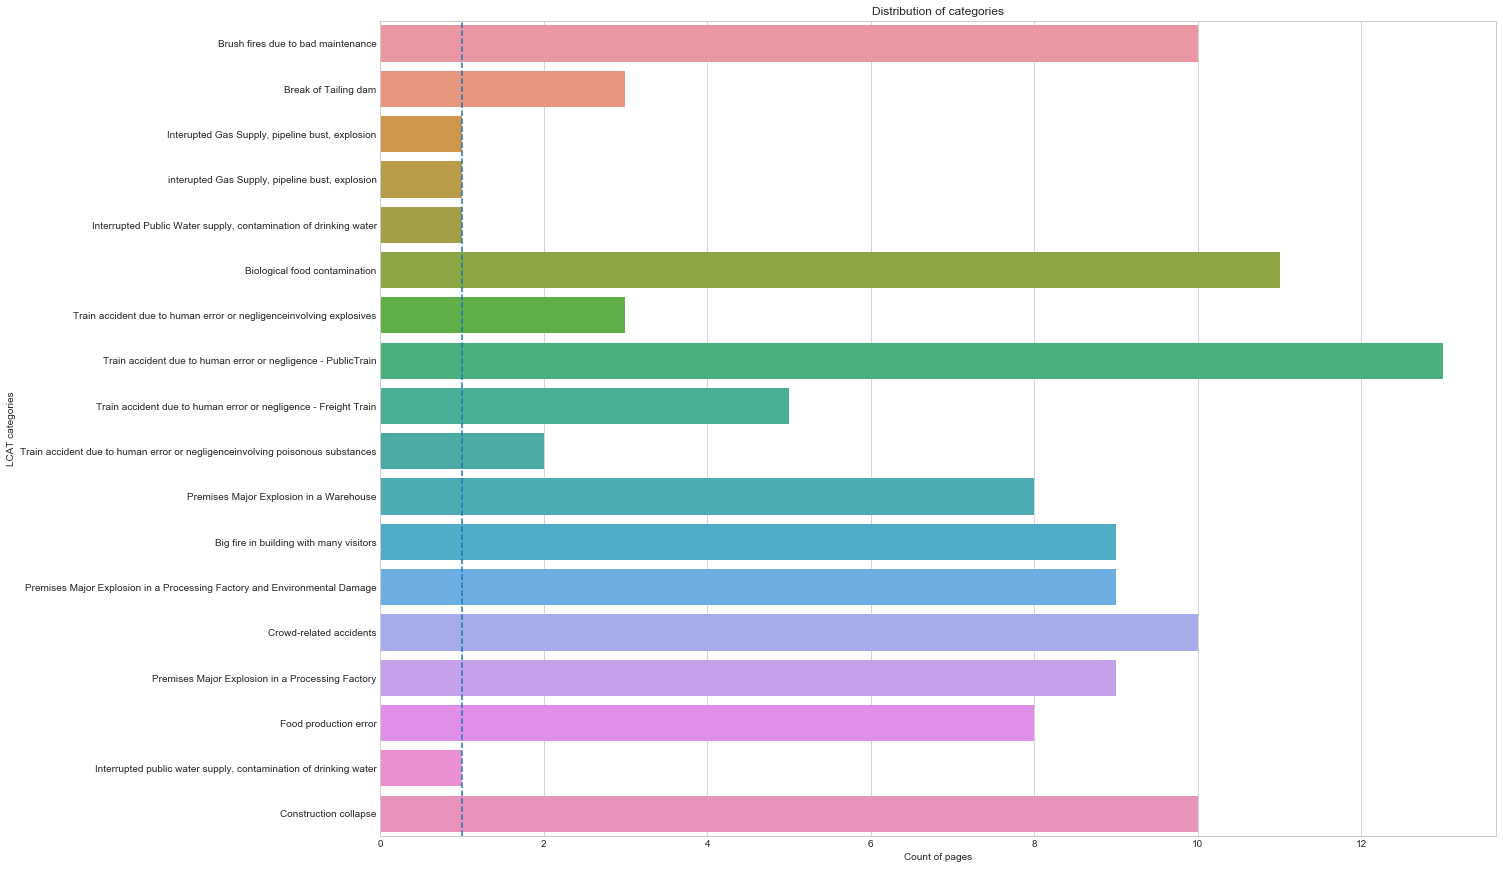

In [68]:
plt.figure(figsize = (20,15))
sns.countplot(y = "Lcat_Scenario",data = train)
plt.axvline(x=1,linestyle='--')
plt.xlabel("Count of pages")
plt.ylabel("LCAT categories")
plt.title("Distribution of categories")
plt.show()

In [69]:
pd.value_counts(train["Lcat_Scenario"])

Train accident due to human error or negligence - PublicTrain                    13
Biological food contamination                                                    11
Crowd-related accidents                                                          10
Construction collapse                                                            10
Brush fires due to bad maintenance                                               10
Premises Major Explosion in a Processing Factory and Environmental Damage         9
Premises Major Explosion in a Processing Factory                                  9
Big fire in building with many visitors                                           9
Food production error                                                             8
Premises Major Explosion in a Warehouse                                           8
Train accident due to human error or negligence - Freight Train                   5
Break of Tailing dam                                                        

In [70]:
train.shape

(114, 5)

In [71]:
os.chdir("DBpedia")
for i in range(len(train["Disaster Name"])):
    try:
       with open(train["Wikipedia Link "][i].replace("https://en.wikipedia.org/wiki/","")+".html","r",encoding = "utf-8") as f:
            data = f.read()
            soup = BeautifulSoup(data)
            if soup.find("span",{'property':'dbo:abstract','xml:lang':'en'}):
                train.loc[i,"Description"] = soup.find("span",{'property':'dbo:abstract','xml:lang':'en'}).text
    except OSError as e:
        pass
    finally:
        pass


In [72]:
train.head()

,Disaster Name,Wikipedia Link,Lcat_Scenario,L-CAT ScenGroup,Lcat_id,Description
0,1900 Hull–Ottawa fire,https://en.wikipedia.org/wiki/1900_Hull%E2%80%...,Brush fires due to bad maintenance,Utility Catastrophe,9016,The Hull-Ottawa fire of 1900 was a devastating...
1,Bento Rodrigues dam disaster,https://en.wikipedia.org/wiki/Bento_Rodrigues_...,Break of Tailing dam,Utility Catastrophe,9015,The Bento Rodrigues dam disaster occurred on 5...
2,Black Saturday bushfires,https://en.wikipedia.org/wiki/Black_Saturday_b...,Brush fires due to bad maintenance,Utility Catastrophe,9016,The Black Saturday bushfires were a series of ...
3,1998 Jesse pipeline explosion,https://en.wikipedia.org/wiki/1998_Jesse_pipel...,"Interupted Gas Supply, pipeline bust, explosion",Utility Catastrophe,9018,"On October 18, 1998 a pipeline explosion occur..."
4,2014 Kaohsiung gas explosions,https://en.wikipedia.org/wiki/2014_Kaohsiung_g...,"interupted Gas Supply, pipeline bust, explosion",Utility Catastrophe,9018,"On 31 July 2014, a series of gas explosions oc..."


In [73]:
labels = list(train["Lcat_Scenario"].str.strip().unique())
index = list(range(len(labels)))
zipped = zip(labels,index)
mapping = dict(zipped)

In [74]:
train["target"] = train["Lcat_Scenario"].str.strip().map(mapping)

In [75]:
print('Preprocessing text...')
cols = [
   'Description'
]
n_features = [
    400
]
train["Description"] = train["Description"].astype(str)

Preprocessing text...


In [76]:
for c_i, c in tqdm(enumerate(cols)):
    tfidf = TfidfVectorizer(max_features=n_features[c_i], min_df=3)
    tfidf.fit(train[c])
    tfidf_train = np.array(tfidf.transform(train[c]).todense(), dtype=np.float16)
    #tfidf_test = np.array(tfidf.transform(test[c]).todense(), dtype=np.float16)

    for i in range(n_features[c_i]):
        train[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
        #test[c + '_tfidf_' + str(i)] = tfidf_test[:, i]
        
    del tfidf, tfidf_train
    gc.collect()

1it [00:00,  4.02it/s]


In [77]:
drop_cols = ["Disaster Name","Wikipedia Link ","Lcat_Scenario","L-CAT ScenGroup","Lcat_id","Description"]
train.drop(drop_cols,axis=1,inplace = True)
X = train.drop("target",axis = 1)
y = train["target"]
feature_names = list(X.columns)

cnt = 0
p_buf = []
n_splits = 5
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=0)
auc_buf = []   

In [78]:
for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class':19,
        'metric':'multi_logloss',
        'max_depth': 16,
        'num_leaves': 31,
        'learning_rate': 0.025,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'verbose': 0,
        'num_threads': 1,
        'lambda_l2': 1,
        'min_gain_to_split': 0,
    }  

    
    model = lgb.train(
        params,
        lgb.Dataset(X.loc[train_index], y.loc[train_index], feature_name=feature_names),
        num_boost_round=1000,
        valid_sets=[lgb.Dataset(X.loc[valid_index], y.loc[valid_index])],
        early_stopping_rounds=100,
        verbose_eval=100,
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        print(tuples[:50])

    p = model.predict(X.loc[valid_index], num_iteration=model.best_iteration)
    p = list(p)
    p = [int(list(np.where(i == i.max()))[0]) for i in p]
    auc = accuracy_score(y.loc[valid_index], p)

    print('{} AUC: {}'.format(cnt, auc))

    #p = model.predict(X_test, num_iteration=model.best_iteration)
    #if len(p_buf) == 0:
     #   p_buf = np.array(p)
    #else:
     #   p_buf += np.array(p)
    auc_buf.append(auc)

    cnt += 1
   # if cnt > 0: # Comment this to run several folds
   #     break
    
    del model
    gc.collect()

auc_mean = np.mean(auc_buf)
auc_std = np.std(auc_buf)
print('ACCURACY = {:.6f} +/- {:.6f}'.format(auc_mean, auc_std))

Fold 1/5
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 2.40069
[200]	valid_0's multi_logloss: 2.24829
[300]	valid_0's multi_logloss: 2.1987
[400]	valid_0's multi_logloss: 2.17757
Early stopping, best iteration is:
[340]	valid_0's multi_logloss: 2.16853
Important features:
[('Description_tfidf_276', 587), ('Description_tfidf_350', 544), ('Description_tfidf_379', 542), ('Description_tfidf_270', 529), ('Description_tfidf_287', 456), ('Description_tfidf_60', 439), ('Description_tfidf_163', 425), ('Description_tfidf_70', 413), ('Description_tfidf_349', 375), ('Description_tfidf_268', 353), ('Description_tfidf_197', 344), ('Description_tfidf_69', 331), ('Description_tfidf_361', 323), ('Description_tfidf_382', 261), ('Description_tfidf_74', 238), ('Description_tfidf_390', 186), ('Description_tfidf_206', 175), ('Description_tfidf_142', 161), ('Description_tfidf_90', 156), ('Description_tfidf_177', 142), ('Description_tfidf_386', 137), ('Descripti

Since we have 19 categories to predict and the training data is not so huge, we get poor performance. Let us try to build the model on the variable "L-CAT ScenGroup" which is at a higher granular level.

In [79]:
os.chdir("\\\\CHRB1067.CORP.GWPNET.COM\\homes\\C\\S5RXCY\\Documents\\\\HactionLab\\Task 3 - LCAT classification")
train = pd.read_excel("Task3 (2).xlsx")
os.chdir("DBpedia")
labels = list(train["L-CAT ScenGroup"].str.strip().unique())
index = list(range(len(labels)))
zipped = zip(labels,index)
mapping = dict(zipped)

In [80]:
train["target"] = train["L-CAT ScenGroup"].str.strip().map(mapping)

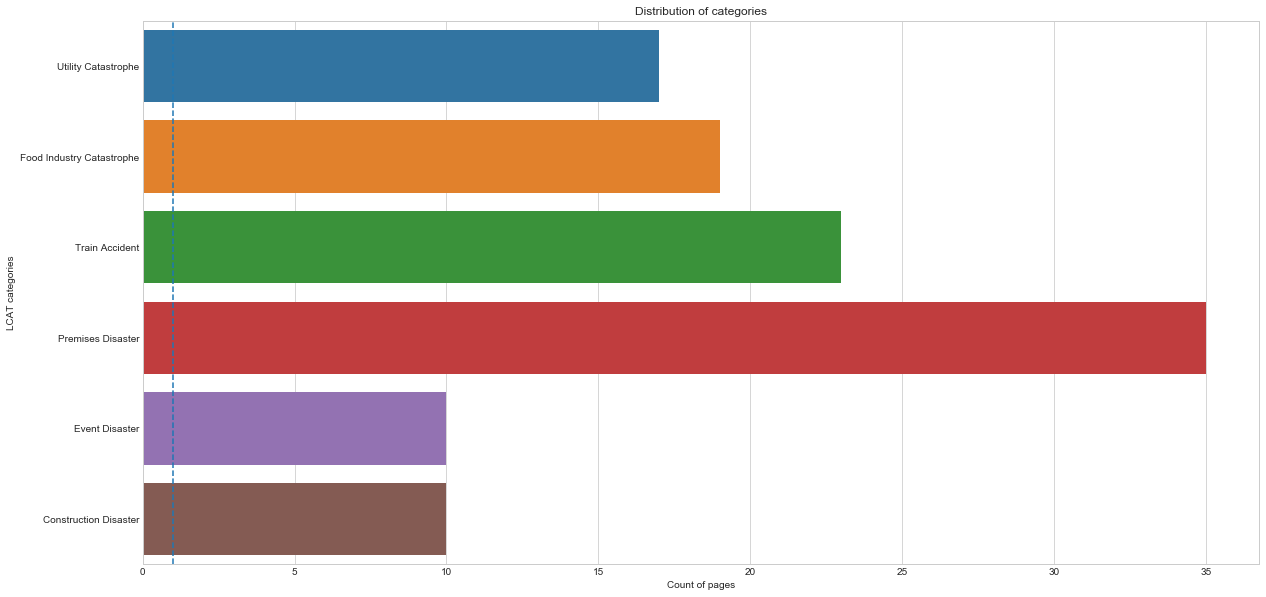

In [81]:
plt.figure(figsize = (20,10))
sns.countplot(y = "L-CAT ScenGroup",data = train)
plt.axvline(x=1,linestyle='--')
plt.xlabel("Count of pages")
plt.ylabel("LCAT categories")
plt.title("Distribution of categories")
plt.show()

In [82]:
train.head()
for i in range(len(train["Disaster Name"])):
    try:
       with open(train["Wikipedia Link "][i].replace("https://en.wikipedia.org/wiki/","")+".html","r",encoding = "utf-8") as f:
            data = f.read()
            soup = BeautifulSoup(data)
            if soup.find("span",{'property':'dbo:abstract','xml:lang':'en'}):
                train.loc[i,"Description"] = soup.find("span",{'property':'dbo:abstract','xml:lang':'en'}).text
    except OSError as e:
        pass
    finally:
        pass

In [83]:
print('Preprocessing text...')
cols = [
   'Description'
]
n_features = [
    400
]
train["Description"] = train["Description"].astype(str)
for c_i, c in tqdm(enumerate(cols)):
    tfidf = TfidfVectorizer(max_features=n_features[c_i], min_df=3)
    tfidf.fit(train[c])
    tfidf_train = np.array(tfidf.transform(train[c]).todense(), dtype=np.float16)
    #tfidf_test = np.array(tfidf.transform(test[c]).todense(), dtype=np.float16)

    for i in range(n_features[c_i]):
        train[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
        #test[c + '_tfidf_' + str(i)] = tfidf_test[:, i]
        
    del tfidf, tfidf_train
    gc.collect()

Preprocessing text...


1it [00:00,  4.88it/s]


In [84]:
drop_cols = ["Disaster Name","Wikipedia Link ","Lcat_Scenario","L-CAT ScenGroup","Lcat_id","Description"]
train.drop(drop_cols,axis=1,inplace = True)
X = train.drop("target",axis = 1)
y = train["target"]
feature_names = list(X.columns)

cnt = 0
p_buf = []
n_splits = 5
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=0)
auc_buf = []   

for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class':19,
        'metric':'multi_logloss',
        'max_depth': 16,
        'num_leaves': 31,
        'learning_rate': 0.025,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'verbose': 0,
        'num_threads': 1,
        'lambda_l2': 1,
        'min_gain_to_split': 0,
    }  

    
    model = lgb.train(
        params,
        lgb.Dataset(X.loc[train_index], y.loc[train_index], feature_name=feature_names),
        num_boost_round=1000,
        valid_sets=[lgb.Dataset(X.loc[valid_index], y.loc[valid_index])],
        early_stopping_rounds=100,
        verbose_eval=100,
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        print(tuples[:50])

    p = model.predict(X.loc[valid_index], num_iteration=model.best_iteration)
    p = list(p)
    p = [int(list(np.where(i == i.max()))[0]) for i in p]
    auc = accuracy_score(y.loc[valid_index], p)

    print('{} AUC: {}'.format(cnt, auc))

    #p = model.predict(X_test, num_iteration=model.best_iteration)
    #if len(p_buf) == 0:
     #   p_buf = np.array(p)
    #else:
     #   p_buf += np.array(p)
    auc_buf.append(auc)

    cnt += 1
   # if cnt > 0: # Comment this to run several folds
    #    break
    
    del model
    gc.collect()

auc_mean = np.mean(auc_buf)
auc_std = np.std(auc_buf)
print('AUC = {:.6f} +/- {:.6f}'.format(auc_mean, auc_std))


Fold 1/5
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 1.28296
[200]	valid_0's multi_logloss: 1.18128
[300]	valid_0's multi_logloss: 1.13421
[400]	valid_0's multi_logloss: 1.10275
[500]	valid_0's multi_logloss: 1.09653
Early stopping, best iteration is:
[445]	valid_0's multi_logloss: 1.09432
Important features:
[('Description_tfidf_276', 391), ('Description_tfidf_349', 385), ('Description_tfidf_70', 357), ('Description_tfidf_350', 304), ('Description_tfidf_270', 291), ('Description_tfidf_287', 284), ('Description_tfidf_60', 268), ('Description_tfidf_361', 267), ('Description_tfidf_379', 257), ('Description_tfidf_197', 240), ('Description_tfidf_163', 228), ('Description_tfidf_382', 210), ('Description_tfidf_268', 188), ('Description_tfidf_42', 168), ('Description_tfidf_69', 131), ('Description_tfidf_90', 108), ('Description_tfidf_59', 94), ('Description_tfidf_390', 93), ('Description_tfidf_170', 92), ('Description_tfidf_206', 82), ('Descri

Thus, with more training data, we will be able to produce better models with good performance. This is a working prototype to showcase the model trained in less than 120 observations